# Chapter 16: Pretraining an Encoder: The BERT Language Model
Toy implementation of dataset preparation and BERT pretraining

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

In [1]:
import regex as re
import os
import random
import torch.nn as nn
import torch
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

A few constants:
1. For the corpus
2. For BERT

In [2]:
# max len per sentence to account for [CLS] and [SEP] the max length of a sequence is 128
maxlen = 60
mask_prob = 0.15  # Percentage of masked tokens
max_predictions = 20  # Max number of masked tokens

In [3]:
d_model = 20  # 768 #50

In [4]:
BATCH_SIZE = 128
EPOCHS = 60

## Corpus Files

We read the files and we store the corpus in a string

In [5]:
PATH = '../datasets/'

In [6]:
CORPUS = 'HOMER'  # 'DICKENS'

In [7]:
if CORPUS == 'DICKENS':
    folder = PATH + 'dickens/'
elif CORPUS == 'HOMER':
    folder = PATH + 'classics/'

In [8]:
def get_files(dir, suffix):
    """
    Returns all the files in a folder ending with suffix
    :param dir:
    :param suffix:
    :return: the list of file names
    """
    files = []
    for file in os.listdir(dir):
        if file.endswith(suffix):
            files.append(file)
    return files

In [9]:
if CORPUS == 'DICKENS':
    files = get_files(folder, 'txt')
elif CORPUS == 'HOMER':
    files = ['iliad.txt', 'odyssey.txt']
files

['iliad.txt', 'odyssey.txt']

In [10]:
files = [folder + file for file in files]
files

['../datasets/classics/iliad.txt', '../datasets/classics/odyssey.txt']

In [11]:
text = ''
for file in files:
    with open(file, encoding='utf8') as f:
        text += ' ' + f.read().strip()

In [12]:
text[:100]

' BOOK I\n\nSing, O goddess, the anger of Achilles son of Peleus, that brought\ncountless ills upon the '

## Creating the Dataset: Preliminary Experiments

In [13]:
first_sentences = [
    'Tell me, O Muse, of that ingenious hero who travelled far and wide after he had sacked the famous town of Troy.',
    'Many cities did he visit, and many were the nations with whose manners and customs he was acquainted;']

In [14]:
sentences_book = [
    'Tell me of that hero',
    'Many cities did he visit']
sentences_book = [
    'Tell me, O Muse, of that ingenious hero',
    'Many cities did he visit',
    'Exiled from home am I ;']

In [15]:
pat = r'\p{P}|[^\s\p{P}]+'

In [16]:
tokenized_sents_book = []
for sent in sentences_book:
    tokenized_sents_book += [re.findall(pat, sent)]

In [17]:
tokenized_sents_book

[['Tell', 'me', ',', 'O', 'Muse', ',', 'of', 'that', 'ingenious', 'hero'],
 ['Many', 'cities', 'did', 'he', 'visit'],
 ['Exiled', 'from', 'home', 'am', 'I', ';']]

### Creating the segments
Simplified code for two sentences
#### The Boundaries

In [18]:
def create_sample(tokens_a, tokens_b, next=True):
    tokens = ['[CLS]'] + tokens_a + ['[SEP]']
    segment_ids = len(tokens) * [0]
    tokens.extend(tokens_b + ['[SEP]'])
    segment_ids += (len(tokens_b) + 1) * [1]
    sample = {'tokens': tokens,
              'segment_ids': segment_ids,
              'is_next': True}
    if not next:
        sample['is_next'] = False
    return sample

In [19]:
dataset_book = []
for i in range(len(tokenized_sents_book) - 1):
    sample = create_sample(tokenized_sents_book[i],
                           tokenized_sents_book[i + 1])
    dataset_book += [sample]

In [20]:
dataset_book

[{'tokens': ['[CLS]',
   'Tell',
   'me',
   ',',
   'O',
   'Muse',
   ',',
   'of',
   'that',
   'ingenious',
   'hero',
   '[SEP]',
   'Many',
   'cities',
   'did',
   'he',
   'visit',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
  'is_next': True},
 {'tokens': ['[CLS]',
   'Many',
   'cities',
   'did',
   'he',
   'visit',
   '[SEP]',
   'Exiled',
   'from',
   'home',
   'am',
   'I',
   ';',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  'is_next': True}]

#### Masking the segments

In [21]:
def mask_tokens(sample,
                mask_prob=0.15,
                max_predictions=20):
    cand_idx = [
        i for i in range(len(sample['tokens']))
        if sample['tokens'][i] not in ['[CLS]', '[SEP]']]
    mask_cnt = max(1, int(round(len(sample['tokens'])
                                * mask_prob)))
    mask_cnt = min(mask_cnt, max_predictions)
    random.shuffle(cand_idx)
    sample['masked_pos'] = sorted(cand_idx[:mask_cnt])
    sample['masked_tokens'] = [
        token for i, token in
        enumerate(sample['tokens'])
        if i in sample['masked_pos']]
    sample['tokens'] = [
        '[MASK]' if i in sample['masked_pos'] else token
        for i, token in enumerate(sample['tokens'])]
    return sample

In [22]:
dataset_book[0]

{'tokens': ['[CLS]',
  'Tell',
  'me',
  ',',
  'O',
  'Muse',
  ',',
  'of',
  'that',
  'ingenious',
  'hero',
  '[SEP]',
  'Many',
  'cities',
  'did',
  'he',
  'visit',
  '[SEP]'],
 'segment_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 'is_next': True}

To have the same output as in the book

In [23]:
while True:
    a = mask_tokens(dataset_book[0].copy())
    if a['masked_tokens'] == ['Muse', 'hero', 'cities']:
        break
for sample in dataset_book[1:]:
    mask_tokens(sample)

In [24]:
dataset_book[0] = a
dataset_book[1]['is_next'] = False
dataset_book

[{'tokens': ['[CLS]',
   'Tell',
   'me',
   ',',
   'O',
   '[MASK]',
   ',',
   'of',
   'that',
   'ingenious',
   '[MASK]',
   '[SEP]',
   'Many',
   '[MASK]',
   'did',
   'he',
   'visit',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
  'is_next': True,
  'masked_pos': [5, 10, 13],
  'masked_tokens': ['Muse', 'hero', 'cities']},
 {'tokens': ['[CLS]',
   'Many',
   'cities',
   'did',
   'he',
   '[MASK]',
   '[SEP]',
   'Exiled',
   'from',
   'home',
   '[MASK]',
   'I',
   ';',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  'is_next': False,
  'masked_pos': [5, 10],
  'masked_tokens': ['visit', 'am']}]

In [25]:
len(dataset_book)

2

## Preprocessing the whole corpus

### Sentence splitting

In [26]:
all_sentences = re.findall(r'\p{Lu}[^.?;!:]+[.?;!:]', text)

In [27]:
all_sentences[:10]

['BOOK I\n\nSing, O goddess, the anger of Achilles son of Peleus, that brought\ncountless ills upon the Achaeans.',
 'Many a brave soul did it send hurrying\ndown to Hades, and many a hero did it yield a prey to dogs and vultures,\nfor so were the counsels of Jove fulfilled from the day on which the\nson of Atreus, king of men, and great Achilles, first fell out with\none another.',
 'And which of the gods was it that set them on to quarrel?',
 'It was the\nson of Jove and Leto;',
 'Atreus had\ndishonoured Chryses his priest.',
 'Now Chryses had come to the ships\nof the Achaeans to free his daughter, and had brought with him a great\nransom:',
 "Apollo wreathed\nwith a suppliant's wreath and he besought the Achaeans, but most of\nall the two sons of Atreus, who were their chiefs.",
 'Sons of Atreus," he cried, "and all other Achaeans, may the gods\nwho dwell in Olympus grant you to sack the city of Priam, and to reach\nyour homes in safety;',
 'Apollo, son of Jove.',
 'On this the res

### Tokenization

In [28]:
tokenized_sents = []
for sent in all_sentences:
    tokenized_sents += [re.findall(pat, sent)[:maxlen]]

In [29]:
tokenized_sents

[['BOOK',
  'I',
  'Sing',
  ',',
  'O',
  'goddess',
  ',',
  'the',
  'anger',
  'of',
  'Achilles',
  'son',
  'of',
  'Peleus',
  ',',
  'that',
  'brought',
  'countless',
  'ills',
  'upon',
  'the',
  'Achaeans',
  '.'],
 ['Many',
  'a',
  'brave',
  'soul',
  'did',
  'it',
  'send',
  'hurrying',
  'down',
  'to',
  'Hades',
  ',',
  'and',
  'many',
  'a',
  'hero',
  'did',
  'it',
  'yield',
  'a',
  'prey',
  'to',
  'dogs',
  'and',
  'vultures',
  ',',
  'for',
  'so',
  'were',
  'the',
  'counsels',
  'of',
  'Jove',
  'fulfilled',
  'from',
  'the',
  'day',
  'on',
  'which',
  'the',
  'son',
  'of',
  'Atreus',
  ',',
  'king',
  'of',
  'men',
  ',',
  'and',
  'great',
  'Achilles',
  ',',
  'first',
  'fell',
  'out',
  'with',
  'one',
  'another',
  '.'],
 ['And',
  'which',
  'of',
  'the',
  'gods',
  'was',
  'it',
  'that',
  'set',
  'them',
  'on',
  'to',
  'quarrel',
  '?'],
 ['It', 'was', 'the', 'son', 'of', 'Jove', 'and', 'Leto', ';'],
 ['Atreus', 'h

### The Indicies

We extract all the words and we add the special tokens

In [30]:
vocabulary = set([word for sent in tokenized_sents for word in sent])

In [31]:
vocabulary.update(['[CLS]', '[SEP]', '[MASK]', '[UNK]'])

We create the indices with the padding symbol at index 0

In [32]:
vocabulary = ['[PAD]'] + sorted(list(vocabulary))

In [33]:
idx2word = dict(enumerate(vocabulary))

In [34]:
word2idx = {word: idx for idx, word in idx2word.items()}

In [35]:
vocab_size = len(vocabulary)
vocab_size

9778

In [36]:
len(tokenized_sents)

10267

In [37]:
unk_id = word2idx['[UNK]']
unk_id

1900

In [38]:
for sent in tokenized_sents:
    print(sent)
    print(list(map(lambda x: word2idx.get(x, unk_id), sent)))
    break

['BOOK', 'I', 'Sing', ',', 'O', 'goddess', ',', 'the', 'anger', 'of', 'Achilles', 'son', 'of', 'Peleus', ',', 'that', 'brought', 'countless', 'ills', 'upon', 'the', 'Achaeans', '.']
[277, 876, 1596, 7, 1209, 4825, 7, 8729, 2102, 6429, 29, 8118, 6429, 1326, 7, 8727, 2795, 3339, 5387, 9186, 8729, 26, 9]


In [39]:
word2idx.get('[SEP]')

1899

### The sequences
We generate the consecutive sequences

In [40]:
dataset = []
for i in range(len(tokenized_sents) - 1):
    sample = create_sample(tokenized_sents[i],
                           tokenized_sents[i + 1])
    dataset += [sample]

In [41]:
dataset[0]['tokens']

['[CLS]',
 'BOOK',
 'I',
 'Sing',
 ',',
 'O',
 'goddess',
 ',',
 'the',
 'anger',
 'of',
 'Achilles',
 'son',
 'of',
 'Peleus',
 ',',
 'that',
 'brought',
 'countless',
 'ills',
 'upon',
 'the',
 'Achaeans',
 '.',
 '[SEP]',
 'Many',
 'a',
 'brave',
 'soul',
 'did',
 'it',
 'send',
 'hurrying',
 'down',
 'to',
 'Hades',
 ',',
 'and',
 'many',
 'a',
 'hero',
 'did',
 'it',
 'yield',
 'a',
 'prey',
 'to',
 'dogs',
 'and',
 'vultures',
 ',',
 'for',
 'so',
 'were',
 'the',
 'counsels',
 'of',
 'Jove',
 'fulfilled',
 'from',
 'the',
 'day',
 'on',
 'which',
 'the',
 'son',
 'of',
 'Atreus',
 ',',
 'king',
 'of',
 'men',
 ',',
 'and',
 'great',
 'Achilles',
 ',',
 'first',
 'fell',
 'out',
 'with',
 'one',
 'another',
 '.',
 '[SEP]']

In [42]:
len(dataset)

10266

We generate the nonconsecutive sequences

In [43]:
for i in range(len(tokenized_sents)):
    j = random.randrange(0, len(tokenized_sents))
    sample = create_sample(tokenized_sents[i],
                           tokenized_sents[j], next=False)
    dataset += [sample]

In [44]:
len(dataset)

20533

In [45]:
dataset[-1]

{'tokens': ['[CLS]',
  'Then',
  'Minerva',
  'assumed',
  'the',
  'form',
  'and',
  'voice',
  'of',
  'Mentor',
  ',',
  'and',
  'presently',
  'made',
  'a',
  'covenant',
  'of',
  'peace',
  'between',
  'the',
  'two',
  'contending',
  'parties',
  '.',
  '[SEP]',
  'Meriones',
  'gathered',
  'them',
  'up',
  'from',
  'the',
  'ground',
  'and',
  'took',
  'them',
  'into',
  'his',
  'own',
  'hands',
  ',',
  'then',
  'he',
  'said',
  'to',
  'Idomeneus',
  ',',
  '"',
  'Lay',
  'on',
  ',',
  'till',
  'you',
  'get',
  'back',
  'to',
  'the',
  'ships',
  ',',
  'for',
  'you',
  'must',
  'see',
  'that',
  'the',
  'day',
  'is',
  'no',
  'longer',
  'ours',
  '.',
  '[SEP]'],
 'segment_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

We mask some tokens

In [46]:
dataset[0]

{'tokens': ['[CLS]',
  'BOOK',
  'I',
  'Sing',
  ',',
  'O',
  'goddess',
  ',',
  'the',
  'anger',
  'of',
  'Achilles',
  'son',
  'of',
  'Peleus',
  ',',
  'that',
  'brought',
  'countless',
  'ills',
  'upon',
  'the',
  'Achaeans',
  '.',
  '[SEP]',
  'Many',
  'a',
  'brave',
  'soul',
  'did',
  'it',
  'send',
  'hurrying',
  'down',
  'to',
  'Hades',
  ',',
  'and',
  'many',
  'a',
  'hero',
  'did',
  'it',
  'yield',
  'a',
  'prey',
  'to',
  'dogs',
  'and',
  'vultures',
  ',',
  'for',
  'so',
  'were',
  'the',
  'counsels',
  'of',
  'Jove',
  'fulfilled',
  'from',
  'the',
  'day',
  'on',
  'which',
  'the',
  'son',
  'of',
  'Atreus',
  ',',
  'king',
  'of',
  'men',
  ',',
  'and',
  'great',
  'Achilles',
  ',',
  'first',
  'fell',
  'out',
  'with',
  'one',
  'another',
  '.',
  '[SEP]'],
 'segment_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
 

In [47]:
for sample in dataset:
    mask_tokens(sample)

In [48]:
dataset[0]

{'tokens': ['[CLS]',
  '[MASK]',
  'I',
  'Sing',
  ',',
  'O',
  'goddess',
  ',',
  '[MASK]',
  'anger',
  'of',
  'Achilles',
  'son',
  'of',
  'Peleus',
  ',',
  'that',
  'brought',
  'countless',
  'ills',
  'upon',
  'the',
  'Achaeans',
  '.',
  '[SEP]',
  'Many',
  'a',
  'brave',
  '[MASK]',
  'did',
  'it',
  'send',
  'hurrying',
  '[MASK]',
  'to',
  'Hades',
  ',',
  'and',
  'many',
  'a',
  'hero',
  'did',
  'it',
  'yield',
  'a',
  'prey',
  '[MASK]',
  'dogs',
  'and',
  '[MASK]',
  ',',
  'for',
  '[MASK]',
  'were',
  'the',
  'counsels',
  '[MASK]',
  'Jove',
  '[MASK]',
  '[MASK]',
  'the',
  'day',
  'on',
  'which',
  'the',
  'son',
  'of',
  'Atreus',
  ',',
  'king',
  'of',
  'men',
  ',',
  'and',
  'great',
  'Achilles',
  '[MASK]',
  'first',
  '[MASK]',
  'out',
  'with',
  '[MASK]',
  'another',
  '.',
  '[SEP]'],
 'segment_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [49]:
dataset_book

[{'tokens': ['[CLS]',
   'Tell',
   'me',
   ',',
   'O',
   '[MASK]',
   ',',
   'of',
   'that',
   'ingenious',
   '[MASK]',
   '[SEP]',
   'Many',
   '[MASK]',
   'did',
   'he',
   'visit',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
  'is_next': True,
  'masked_pos': [5, 10, 13],
  'masked_tokens': ['Muse', 'hero', 'cities']},
 {'tokens': ['[CLS]',
   'Many',
   'cities',
   'did',
   'he',
   '[MASK]',
   '[SEP]',
   'Exiled',
   'from',
   'home',
   '[MASK]',
   'I',
   ';',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  'is_next': False,
  'masked_pos': [5, 10],
  'masked_tokens': ['visit', 'am']}]

In [50]:
dataset[0]

{'tokens': ['[CLS]',
  '[MASK]',
  'I',
  'Sing',
  ',',
  'O',
  'goddess',
  ',',
  '[MASK]',
  'anger',
  'of',
  'Achilles',
  'son',
  'of',
  'Peleus',
  ',',
  'that',
  'brought',
  'countless',
  'ills',
  'upon',
  'the',
  'Achaeans',
  '.',
  '[SEP]',
  'Many',
  'a',
  'brave',
  '[MASK]',
  'did',
  'it',
  'send',
  'hurrying',
  '[MASK]',
  'to',
  'Hades',
  ',',
  'and',
  'many',
  'a',
  'hero',
  'did',
  'it',
  'yield',
  'a',
  'prey',
  '[MASK]',
  'dogs',
  'and',
  '[MASK]',
  ',',
  'for',
  '[MASK]',
  'were',
  'the',
  'counsels',
  '[MASK]',
  'Jove',
  '[MASK]',
  '[MASK]',
  'the',
  'day',
  'on',
  'which',
  'the',
  'son',
  'of',
  'Atreus',
  ',',
  'king',
  'of',
  'men',
  ',',
  'and',
  'great',
  'Achilles',
  '[MASK]',
  'first',
  '[MASK]',
  'out',
  'with',
  '[MASK]',
  'another',
  '.',
  '[SEP]'],
 'segment_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [51]:
def add_indices(sample, word2idx):
    tokens = sample['tokens']
    sample['token_ids'] = list(map(lambda x: word2idx.get(x, unk_id), tokens))
    masked_tokens = sample['masked_tokens']
    sample['masked_ids'] = list(
        map(lambda x: word2idx.get(x, unk_id), masked_tokens))
    return sample

In [52]:
for sample in dataset:
    add_indices(sample, word2idx)

In [53]:
dataset[0]

{'tokens': ['[CLS]',
  '[MASK]',
  'I',
  'Sing',
  ',',
  'O',
  'goddess',
  ',',
  '[MASK]',
  'anger',
  'of',
  'Achilles',
  'son',
  'of',
  'Peleus',
  ',',
  'that',
  'brought',
  'countless',
  'ills',
  'upon',
  'the',
  'Achaeans',
  '.',
  '[SEP]',
  'Many',
  'a',
  'brave',
  '[MASK]',
  'did',
  'it',
  'send',
  'hurrying',
  '[MASK]',
  'to',
  'Hades',
  ',',
  'and',
  'many',
  'a',
  'hero',
  'did',
  'it',
  'yield',
  'a',
  'prey',
  '[MASK]',
  'dogs',
  'and',
  '[MASK]',
  ',',
  'for',
  '[MASK]',
  'were',
  'the',
  'counsels',
  '[MASK]',
  'Jove',
  '[MASK]',
  '[MASK]',
  'the',
  'day',
  'on',
  'which',
  'the',
  'son',
  'of',
  'Atreus',
  ',',
  'king',
  'of',
  'men',
  ',',
  'and',
  'great',
  'Achilles',
  '[MASK]',
  'first',
  '[MASK]',
  'out',
  'with',
  '[MASK]',
  'another',
  '.',
  '[SEP]'],
 'segment_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [54]:
for sample in dataset_book:
    add_indices(sample, word2idx)

In [55]:
dataset_book

[{'tokens': ['[CLS]',
   'Tell',
   'me',
   ',',
   'O',
   '[MASK]',
   ',',
   'of',
   'that',
   'ingenious',
   '[MASK]',
   '[SEP]',
   'Many',
   '[MASK]',
   'did',
   'he',
   'visit',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
  'is_next': True,
  'masked_pos': [5, 10, 13],
  'masked_tokens': ['Muse', 'hero', 'cities'],
  'token_ids': [1897,
   1688,
   6052,
   7,
   1209,
   1898,
   7,
   6429,
   8727,
   5464,
   1898,
   1899,
   1064,
   1898,
   3681,
   5076,
   9309,
   1899],
  'masked_ids': [1147, 5184, 3068]},
 {'tokens': ['[CLS]',
   'Many',
   'cities',
   'did',
   'he',
   '[MASK]',
   '[SEP]',
   'Exiled',
   'from',
   'home',
   '[MASK]',
   'I',
   ';',
   '[SEP]'],
  'segment_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
  'is_next': False,
  'masked_pos': [5, 10],
  'masked_tokens': ['visit', 'am'],
  'token_ids': [1897,
   1064,
   3068,
   3681,
   5076,
   1898,
   1899,
   1900,
   4657,
   5254,
   18

We convert the index lists into tensors

In [56]:
for sample in dataset_book:
    sample['token_ids'] = torch.LongTensor(sample['token_ids'])
    sample['segment_ids'] = torch.LongTensor(sample['segment_ids'])
    sample['masked_ids'] = torch.LongTensor(sample['masked_ids'])

In [57]:
dataset_book

[{'tokens': ['[CLS]',
   'Tell',
   'me',
   ',',
   'O',
   '[MASK]',
   ',',
   'of',
   'that',
   'ingenious',
   '[MASK]',
   '[SEP]',
   'Many',
   '[MASK]',
   'did',
   'he',
   'visit',
   '[SEP]'],
  'segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]),
  'is_next': True,
  'masked_pos': [5, 10, 13],
  'masked_tokens': ['Muse', 'hero', 'cities'],
  'token_ids': tensor([1897, 1688, 6052,    7, 1209, 1898,    7, 6429, 8727, 5464, 1898, 1899,
          1064, 1898, 3681, 5076, 9309, 1899]),
  'masked_ids': tensor([1147, 5184, 3068])},
 {'tokens': ['[CLS]',
   'Many',
   'cities',
   'did',
   'he',
   '[MASK]',
   '[SEP]',
   'Exiled',
   'from',
   'home',
   '[MASK]',
   'I',
   ';',
   '[SEP]'],
  'segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]),
  'is_next': False,
  'masked_pos': [5, 10],
  'masked_tokens': ['visit', 'am'],
  'token_ids': tensor([1897, 1064, 3068, 3681, 5076, 1898, 1899, 1900, 4657, 5254, 1898,  876,
            11, 

In [58]:
for sample in dataset:
    sample['token_ids'] = torch.LongTensor(sample['token_ids'])
    sample['segment_ids'] = torch.LongTensor(sample['segment_ids'])
    sample['masked_ids'] = torch.LongTensor(sample['masked_ids'])

In [59]:
dataset[0]

{'tokens': ['[CLS]',
  '[MASK]',
  'I',
  'Sing',
  ',',
  'O',
  'goddess',
  ',',
  '[MASK]',
  'anger',
  'of',
  'Achilles',
  'son',
  'of',
  'Peleus',
  ',',
  'that',
  'brought',
  'countless',
  'ills',
  'upon',
  'the',
  'Achaeans',
  '.',
  '[SEP]',
  'Many',
  'a',
  'brave',
  '[MASK]',
  'did',
  'it',
  'send',
  'hurrying',
  '[MASK]',
  'to',
  'Hades',
  ',',
  'and',
  'many',
  'a',
  'hero',
  'did',
  'it',
  'yield',
  'a',
  'prey',
  '[MASK]',
  'dogs',
  'and',
  '[MASK]',
  ',',
  'for',
  '[MASK]',
  'were',
  'the',
  'counsels',
  '[MASK]',
  'Jove',
  '[MASK]',
  '[MASK]',
  'the',
  'day',
  'on',
  'which',
  'the',
  'son',
  'of',
  'Atreus',
  ',',
  'king',
  'of',
  'men',
  ',',
  'and',
  'great',
  'Achilles',
  '[MASK]',
  'first',
  '[MASK]',
  'out',
  'with',
  '[MASK]',
  'another',
  '.',
  '[SEP]'],
 'segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [60]:
dataset[1]['token_ids']

tensor([1897, 1064, 1902, 2715, 8141, 3681, 5555, 7745, 5358, 3846, 1898,  773,
        1898, 2099, 6001, 1902, 5184, 1898, 5555, 9754, 1902, 6962, 8867, 3820,
        1898, 9339,    7, 4547, 8085, 9486, 8729, 3335, 6429,  953, 4672, 4657,
        8729, 1898, 6462, 1898, 8729, 8118, 6429,  261,    7, 5635, 6429, 6088,
        1898, 2099, 4884,   29,    7, 4425, 4349, 1898, 9610, 6464, 2115,    9,
        1899, 1898, 9517, 1898, 8729, 4828, 9409, 5555, 8727, 7773, 1898, 6462,
        8867, 7097,   12, 1899])

In [61]:
dataset[1]['segment_ids']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [62]:
dataset[1]['masked_ids']

tensor([8867,    7, 3681, 2099, 3525, 9517,    7, 6512,  170, 6429, 8733])

Padding experiment with the first and second example

In [63]:
len(dataset_book)

2

In [64]:
book_t_ids = torch.nn.utils.rnn.pad_sequence(
    (dataset_book[0]['token_ids'], dataset_book[1]['token_ids']), batch_first=True)
book_s_ids = torch.nn.utils.rnn.pad_sequence(
    (dataset_book[0]['segment_ids'], dataset_book[1]['segment_ids']), batch_first=True)

In [65]:
book_t_ids

tensor([[1897, 1688, 6052,    7, 1209, 1898,    7, 6429, 8727, 5464, 1898, 1899,
         1064, 1898, 3681, 5076, 9309, 1899],
        [1897, 1064, 3068, 3681, 5076, 1898, 1899, 1900, 4657, 5254, 1898,  876,
           11, 1899,    0,    0,    0,    0]])

In [66]:
book_s_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])

### Batch Inputs
We create a batch of sequences. We align them into a tensor and we keep the padding positions. We return:
1. The token indices
2. The segment indices, either 0 or 1
3. If the segment A follows B
4. The masked positions
5. Their values as indices
6. The end padding

In [67]:
def make_batch(dataset, start, BATCH_SIZE=BATCH_SIZE):
    tok_ids = []
    seg_ids = []
    masked_pos = []
    masked_ids = []

    y_nsp = []
    if len(dataset) < start + BATCH_SIZE:
        end = len(dataset)
    else:
        end = start + BATCH_SIZE
    for i in range(start, end):
        tok_ids += [dataset[i]['token_ids']]
        masked_pos += [dataset[i]['masked_pos']]
        masked_ids += [dataset[i]['masked_ids']]
        seg_ids += [dataset[i]['segment_ids']]
        if dataset[i]['is_next']:
            y_nsp += [1]
        else:
            y_nsp += [0]

    y_nsp = torch.LongTensor(y_nsp)
    tok_ids = torch.nn.utils.rnn.pad_sequence(tok_ids,
                                              batch_first=True)
    seg_ids = torch.nn.utils.rnn.pad_sequence(seg_ids,
                                              batch_first=True)
    return tok_ids, seg_ids, y_nsp, masked_pos, masked_ids

In [68]:
tok_ids, seg_ids, y_nsp, masked_pos, masked_ids = make_batch(dataset, 0)

In [69]:
tok_ids[0]

tensor([1897, 1898,  876, 1596,    7, 1209, 4825,    7, 1898, 2102, 6429,   29,
        8118, 6429, 1326,    7, 8727, 2795, 3339, 5387, 9186, 8729,   26,    9,
        1899, 1064, 1902, 2715, 1898, 3681, 5555, 7745, 5358, 1898, 8867,  773,
           7, 2099, 6001, 1902, 5184, 3681, 5555, 9754, 1902, 6962, 1898, 3820,
        2099, 1898,    7, 4547, 1898, 9486, 8729, 3335, 1898,  953, 1898, 1898,
        8729, 3525, 6462, 9517, 8729, 8118, 6429,  261,    7, 5635, 6429, 6088,
           7, 2099, 4884,   29, 1898, 4425, 1898, 6512, 9610, 1898, 2115,    9,
        1899,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [70]:
seg_ids[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We check this is working for the whole dataset

In [71]:
n_batches = int(len(dataset) / BATCH_SIZE) + 1
n_batches

161

In [72]:
for i in tqdm(range(n_batches)):
    tok_ids, seg_ids, y_nsp, masked_pos, masked_ids = make_batch(
        dataset, BATCH_SIZE * i)

100%|██████████| 161/161 [00:00<00:00, 2823.03it/s]


## The Embeddings

In [73]:
class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size,
                 d_model=d_model,
                 maxlen=512,
                 n_segments=2,
                 dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.tok_embedding = nn.Embedding(vocab_size, d_model,
                                          padding_idx=0)
        self.pos_embedding = nn.Embedding(maxlen, d_model)
        self.seg_embedding = nn.Embedding(n_segments, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, token_ids, segment_ids):
        pos_ids = torch.arange(token_ids.size(dim=1),
                               dtype=torch.long).unsqueeze(0)
        # We create a batch
        # pos_ids = pos_ids.repeat(token_ids.size(0), 1)
        embedding = self.tok_embedding(token_ids) + \
            self.pos_embedding(pos_ids) + \
            self.seg_embedding(segment_ids)
        return self.layer_norm(self.dropout(embedding))

In [74]:
embeddings = BERTEmbedding(vocab_size)

In [75]:
dataset[5925]['token_ids']

tensor([1897,  170, 1124, 7585,    7,    2, 1898, 5548, 6345, 1898, 6429, 9769,
        1898, 3939, 6512, 9753,    7, 9519, 1334, 5047, 8495, 1898, 4405, 8118,
        2193, 1898, 2164,    9, 1899,  328, 8696, 6052,    7, 1898, 1898, 6052,
        8998,    7, 9490, 5548, 8729, 6062, 6429, 2049, 8777, 4329,    7, 2099,
        9540, 2164, 1898, 6685,   12, 1899])

In [76]:
embeddings(dataset[0]['token_ids'].unsqueeze(0),
           dataset[0]['segment_ids'].unsqueeze(0)).size()

torch.Size([1, 85, 20])

In [77]:
embeddings(dataset_book[0]['token_ids'].unsqueeze(0),
           dataset_book[0]['segment_ids'].unsqueeze(0)).size()

torch.Size([1, 18, 20])

In [78]:
len(dataset[5926]['token_ids'])

33

In [79]:
for i, seq in tqdm(enumerate(dataset)):
    embeddings(seq['token_ids'].unsqueeze(0), seq['segment_ids'].unsqueeze(0))

20533it [00:01, 16366.63it/s]


In [80]:
embeddings(book_t_ids, book_s_ids)

tensor([[[-6.4802e-02,  1.1113e+00, -1.3840e+00, -1.6329e+00, -1.0212e-01,
           3.6445e-01, -9.1030e-01, -3.6837e-01, -1.2143e-01, -7.2769e-01,
           1.1422e+00, -1.3009e+00,  1.3879e+00,  6.8018e-01,  7.4150e-01,
          -1.2143e-01, -1.0507e-01, -8.7300e-01,  2.4060e+00, -1.2143e-01],
         [-1.3572e+00,  7.3608e-01, -1.2816e+00,  8.1630e-01,  1.2219e+00,
          -7.6612e-01,  3.8697e-01,  5.4110e-01,  1.9076e+00,  2.4004e-02,
          -1.6235e+00, -1.1464e+00, -5.5190e-02,  7.8276e-01, -7.7740e-01,
          -1.1363e-01,  1.1733e+00, -2.4157e-01, -1.2320e+00,  1.0047e+00],
         [ 1.9880e+00,  3.3375e-01,  5.7401e-01, -1.4201e-02,  1.6935e+00,
          -1.4201e-02, -9.3609e-01, -6.2956e-01, -3.6145e-01, -7.6008e-01,
          -1.1107e+00, -2.9009e-01, -1.0218e+00,  2.0987e+00,  4.7922e-02,
          -7.6257e-01, -1.6416e+00, -1.8212e-01,  1.8531e-01,  8.0336e-01],
         [ 4.9641e-01,  4.1957e-01, -3.0869e-01, -9.0899e-01, -1.6706e+00,
          -5.7551e-02,

## The BERT Encoder

In [81]:
class BERT(nn.Module):
    def __init__(self, vocab_size,
                 d_model=768,
                 maxlen=128,
                 n_segments=2,
                 nhead=8,
                 num_layers=12):
        super().__init__()
        self.embeddings = BERTEmbedding(vocab_size,
                                        d_model,
                                        maxlen,
                                        n_segments)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model,
            batch_first=True,
            nhead=nhead,
            dim_feedforward=4 * d_model)
        self.encoder = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=num_layers)

    def forward(self, token_ids, segment_ids):
        padding_mask = (token_ids == 0)
        embeddings = self.embeddings(token_ids, segment_ids)
        y = self.encoder(embeddings,
                         src_key_padding_mask=padding_mask)
        return y

In [82]:
# See https://stackoverflow.com/questions/62170439/difference-between-src-mask-and-src-key-padding-mask

In [83]:
bert = BERT(vocab_size)

In [84]:
tok_ids, seg_ids, _, _, _ = make_batch(dataset, 0)

In [85]:
bert(tok_ids, seg_ids).size()

torch.Size([128, 112, 768])

In [86]:
dataset[0].keys()

dict_keys(['tokens', 'segment_ids', 'is_next', 'masked_pos', 'masked_tokens', 'token_ids', 'masked_ids'])

Computing the embeddings with a batch of two examples

In [87]:
bert(book_t_ids, book_s_ids).size()

torch.Size([2, 18, 768])

In [88]:
Z = bert(book_t_ids, book_s_ids)

In [89]:
Z

tensor([[[-0.9457, -0.8395, -0.1539,  ...,  1.4759,  0.1264, -1.0831],
         [-1.1912, -1.0722,  0.1217,  ...,  1.1816, -0.0837, -0.9258],
         [-0.8484, -1.2201,  0.2628,  ...,  1.4955,  0.2907, -1.0437],
         ...,
         [-0.9893, -1.1735,  0.1899,  ...,  0.9422,  0.1537, -1.0373],
         [-0.9094, -0.7940,  0.0537,  ...,  1.3812,  0.1445, -1.3696],
         [-1.4473, -0.5661,  0.3266,  ...,  1.2665,  0.0131, -1.2143]],

        [[-1.4003, -0.4257,  0.1788,  ...,  0.5581,  0.6556, -1.0240],
         [-1.5494, -0.0233,  0.2763,  ...,  0.7989,  0.5323, -0.8414],
         [-1.7706, -0.5540,  0.4992,  ...,  0.6294,  0.7551, -0.9667],
         ...,
         [-1.8045, -0.9042,  0.4587,  ...,  0.5380,  0.4663, -0.9293],
         [-0.6388, -0.2553,  0.7039,  ...,  0.8637,  0.1010, -1.1326],
         [-1.8356, -0.3305,  0.5655,  ...,  0.8638,  0.5501, -0.6884]]],
       grad_fn=<NativeLayerNormBackward0>)

In [90]:
Z[:, 0, :]

tensor([[-0.9457, -0.8395, -0.1539,  ...,  1.4759,  0.1264, -1.0831],
        [-1.4003, -0.4257,  0.1788,  ...,  0.5581,  0.6556, -1.0240]],
       grad_fn=<SliceBackward0>)

With a batch of one example

In [91]:
dataset[0]['token_ids'].unsqueeze(dim=0)

tensor([[1897, 1898,  876, 1596,    7, 1209, 4825,    7, 1898, 2102, 6429,   29,
         8118, 6429, 1326,    7, 8727, 2795, 3339, 5387, 9186, 8729,   26,    9,
         1899, 1064, 1902, 2715, 1898, 3681, 5555, 7745, 5358, 1898, 8867,  773,
            7, 2099, 6001, 1902, 5184, 3681, 5555, 9754, 1902, 6962, 1898, 3820,
         2099, 1898,    7, 4547, 1898, 9486, 8729, 3335, 1898,  953, 1898, 1898,
         8729, 3525, 6462, 9517, 8729, 8118, 6429,  261,    7, 5635, 6429, 6088,
            7, 2099, 4884,   29, 1898, 4425, 1898, 6512, 9610, 1898, 2115,    9,
         1899]])

In [92]:
bert(dataset[0]['token_ids'].unsqueeze(dim=0),
     dataset[0]['segment_ids'].unsqueeze(dim=0))

tensor([[[-0.9657, -0.3104, -0.5413,  ...,  0.1279,  0.1312, -1.0215],
         [-1.3894, -0.4176,  0.3269,  ...,  0.4225,  0.2566, -0.6030],
         [-1.3499, -0.4654,  0.1756,  ...,  0.5130, -0.1225, -0.7576],
         ...,
         [-1.3719, -0.3732,  0.1907,  ...,  0.3640,  0.0705, -1.1502],
         [-1.8630, -0.2616,  0.5841,  ...,  0.7581,  0.3738, -1.1111],
         [-1.7737, -0.3147,  0.2140,  ...,  0.4249,  0.3035, -0.8412]]],
       grad_fn=<NativeLayerNormBackward0>)

In [93]:
for i, seq in tqdm(enumerate(dataset[:100])):
    bert(seq['token_ids'].unsqueeze(dim=0),
         seq['segment_ids'].unsqueeze(dim=0))

100it [00:04, 22.86it/s]


In [94]:
dataset[-1]['is_next']

False

## The Language Model

In [95]:
class BERTLM(nn.Module):
    def __init__(self, vocab_size,
                 d_model=768,
                 maxlen=128,
                 n_segments=2,
                 nhead=8,
                 num_layers=12):
        super().__init__()
        self.bert = BERT(vocab_size, d_model=d_model,
                         maxlen=maxlen,
                         n_segments=n_segments,
                         nhead=nhead,
                         num_layers=num_layers)
        self.masked_lm = nn.Linear(d_model, vocab_size)
        self.masked_lm.weight = self.bert.embeddings.tok_embedding.weight
        # self.masked_lm_bias = nn.Parameter(torch.zeros(1, vocab_size))
        self.next_sentence = nn.Linear(d_model, 2)

    def forward(self, token_ids,
                segment_ids,
                masked_pos):
        y = self.bert(token_ids, segment_ids)
        # we extract the masked positions
        # y_lm = y[:, masked_pos, :]
        y_lm = self.extract_rows(y, masked_pos)
        y_lm = self.masked_lm(y_lm)
        y_nsp = y[:, 0, :]  # we extract CLS
        y_nsp = self.next_sentence(y_nsp)
        return y_lm, y_nsp

    def extract_rows(self, matrix, row_ids):
        y_lm_pred = []
        for x in range(matrix.size(dim=0)):
            y_lm_pred += [matrix[x, row_ids[x]]]
        return torch.cat(y_lm_pred)

In [96]:
bert_lm = BERTLM(vocab_size, nhead=2, num_layers=2, d_model=d_model)

In [97]:
tok_ids, seg_ids, y_nsp, masked_pos, masked_ids = make_batch(dataset, 0)
# tok_ids, seg_ids, y_nsp, masked_pos, masked_ids = make_batch(dataset_book, 0)

In [98]:
tok_ids

tensor([[1897, 1898,  876,  ...,    0,    0,    0],
        [1897, 1064, 1902,  ...,    0,    0,    0],
        [1897,  170, 9517,  ...,    0,    0,    0],
        ...,
        [1897,  876, 7889,  ...,    0,    0,    0],
        [1897, 1258, 6503,  ...,    0,    0,    0],
        [1897, 1898,  876,  ...,    0,    0,    0]])

In [99]:
seg_ids

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [100]:
masked_pos

[[1, 8, 28, 33, 46, 49, 52, 56, 58, 59, 76, 78, 81],
 [10, 12, 17, 24, 37, 39, 48, 55, 61, 63, 70],
 [10, 11, 12, 19],
 [12, 14, 16],
 [10, 15, 19, 20, 27],
 [7, 27, 33, 38, 40, 44, 45, 52],
 [1, 7, 9, 15, 18, 20, 27, 58, 63, 67],
 [3, 7, 9, 14, 38, 40, 43],
 [11, 19, 21, 23, 25],
 [1, 3, 4, 17, 18, 26],
 [3, 5, 18, 20, 30, 32],
 [4, 6, 11, 18, 36, 37],
 [8, 12, 13],
 [1, 8, 16, 22, 32],
 [2, 10, 11, 13, 31],
 [6, 14, 16, 17, 21, 31],
 [9, 12, 15, 18, 23, 29, 30, 52, 60, 63],
 [6, 9, 14, 15, 23, 40, 48, 52, 56, 61, 64, 66],
 [16, 18, 21, 27, 41, 45, 47, 50],
 [4, 10, 21, 24, 33, 38, 47],
 [9, 19, 21, 31, 32, 45, 46, 49, 54, 65, 67],
 [1, 2, 11, 18, 29, 35, 43, 48, 59, 60],
 [3, 7, 29, 36, 40, 52, 55, 60, 64, 65, 73, 76],
 [2, 6, 7, 16, 18, 33, 38, 55, 59],
 [6, 7, 23, 28, 32, 37, 49, 50],
 [9, 10, 21, 24, 25, 32, 37, 74, 79, 80, 84, 87, 89, 93, 94],
 [6, 9, 12, 16, 23, 35, 60, 72, 82, 84, 85, 87, 88, 90],
 [5, 16, 26, 35, 45, 51, 52, 55, 56],
 [2, 3, 4, 9, 11, 16],
 [6, 12, 21, 25, 34,

In [101]:
Y_lm_pred, Y_nsp_pred = bert_lm(tok_ids, seg_ids, masked_pos)

In [102]:
Y_lm_pred.size(), Y_nsp_pred.size()

(torch.Size([918, 9778]), torch.Size([128, 2]))

In [103]:
Y_lm_pred

tensor([[-0.1717, -1.9812, -0.1214,  ...,  1.4563, -0.2403, -7.0685],
        [-0.1717,  1.8923, -1.2863,  ...,  0.6287, -3.7112, -3.4862],
        [-0.1717, -0.4570, -0.5593,  ..., -0.3462, -5.6379,  1.6689],
        ...,
        [-0.1717, -1.4115, -0.7103,  ...,  0.3558, -1.1894, -4.1199],
        [-0.1717,  3.1767, -3.4940,  ..., -2.4012, -8.6908,  0.5557],
        [-0.1717,  0.1793, -4.7546,  ..., -0.6204, -5.2369,  2.5564]],
       grad_fn=<AddmmBackward0>)

## Training the Language Model

In [104]:
# bert_lm = torch.compile(bert_lm)

In [105]:
loss_fn = nn.CrossEntropyLoss()

In [106]:
optimizer = torch.optim.NAdam(bert_lm.parameters(), lr=0.01)

In [107]:
bert_lm.train()

BERTLM(
  (bert): BERT(
    (embeddings): BERTEmbedding(
      (tok_embedding): Embedding(9778, 20, padding_idx=0)
      (pos_embedding): Embedding(128, 20)
      (seg_embedding): Embedding(2, 20)
      (dropout): Dropout(p=0.1, inplace=False)
      (layer_norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    )
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
      )
      (linear1): Linear(in_features=20, out_features=80, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=80, out_features=20, bias=True)
      (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
    

In [108]:
random.shuffle(dataset)

In [109]:
BATCH_SIZE

128

In [110]:
dataset_fast = dataset[:256]

In [111]:
history = {}
history['loss_lm'] = []
history['loss_nsp'] = []

In [112]:
for epoch in range(EPOCHS):
    random.shuffle(dataset)
    loss_sum_lm = 0
    loss_sum_nsp = 0
    bert_lm.train()
    for i in tqdm(range(n_batches)):
        t_ids, s_ids, y_nsp, masked_pos, masked_ids = make_batch(
            dataset, BATCH_SIZE * i)
        y_lm_pred, y_nsp_pred = bert_lm(
            t_ids, s_ids, masked_pos)
        masked_ids = torch.LongTensor(
            [id for ids in masked_ids for id in ids])
        loss_nsp = loss_fn(y_nsp_pred, y_nsp)
        loss_lm = loss_fn(y_lm_pred, masked_ids)
        loss = loss_nsp + loss_lm
        # loss = loss_nsp
        loss_sum_lm += loss_lm.item()
        loss_sum_nsp += loss_nsp.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if i % 50 == 0:
        #    print(i)
    bert_lm.eval()
    with torch.no_grad():
        history['loss_lm'] += [loss_sum_lm/n_batches]
        history['loss_nsp'] += [loss_sum_nsp/n_batches]
        print(loss_sum_lm/n_batches, loss_sum_nsp/n_batches)

100%|██████████| 161/161 [00:17<00:00,  9.09it/s]


7.531295767482023 0.6973653528260888


100%|██████████| 161/161 [00:19<00:00,  8.44it/s]


6.231736005463215 0.6940264923972372


100%|██████████| 161/161 [00:18<00:00,  8.68it/s]


6.203100755347968 0.6941825292125252


100%|██████████| 161/161 [00:17<00:00,  9.34it/s]


6.181636626676003 0.6941880728147045


100%|██████████| 161/161 [00:17<00:00,  9.16it/s]


6.155235355685217 0.6940861151825567


100%|██████████| 161/161 [00:18<00:00,  8.94it/s]


6.14249461037772 0.6940646534380706


100%|██████████| 161/161 [00:18<00:00,  8.73it/s]


6.134067520591783 0.6939422825108403


100%|██████████| 161/161 [00:17<00:00,  8.99it/s]


6.120327161706013 0.6942245863979648


100%|██████████| 161/161 [00:17<00:00,  9.44it/s]


6.0951026952044565 0.6940301997320992


100%|██████████| 161/161 [00:17<00:00,  9.25it/s]


6.061924762607362 0.6938401930820868


100%|██████████| 161/161 [00:17<00:00,  8.95it/s]


6.02582725975084 0.69365892573173


100%|██████████| 161/161 [00:17<00:00,  9.23it/s]


5.998505624925127 0.6938144609054423


100%|██████████| 161/161 [00:17<00:00,  9.44it/s]


5.977371153624161 0.6942540636714201


100%|██████████| 161/161 [00:16<00:00,  9.81it/s]


5.957655346911887 0.693907212026371


100%|██████████| 161/161 [00:19<00:00,  8.11it/s]


5.943143056786579 0.6939843981902792


100%|██████████| 161/161 [00:23<00:00,  6.85it/s]


5.9289029695972895 0.6936745947192174


100%|██████████| 161/161 [00:25<00:00,  6.30it/s]


5.912266867501395 0.693836023718674


100%|██████████| 161/161 [00:22<00:00,  7.24it/s]


5.890087651910249 0.6936394927664573


100%|██████████| 161/161 [00:22<00:00,  7.01it/s]


5.851485154643562 0.6936770040796411


100%|██████████| 161/161 [00:22<00:00,  7.02it/s]


5.812863746785229 0.6935720214192171


100%|██████████| 161/161 [00:24<00:00,  6.57it/s]


5.781154371936869 0.6908983536388563


100%|██████████| 161/161 [00:23<00:00,  6.94it/s]


5.745795709005794 0.6864573340978681


100%|██████████| 161/161 [00:24<00:00,  6.70it/s]


5.707145234812861 0.6831841242979773


100%|██████████| 161/161 [00:22<00:00,  7.02it/s]


5.6674270866820535 0.6785618933091252


100%|██████████| 161/161 [00:22<00:00,  7.12it/s]


5.625818507271524 0.6756376090997495


100%|██████████| 161/161 [00:22<00:00,  7.15it/s]


5.577852429810518 0.6705899945697429


100%|██████████| 161/161 [00:22<00:00,  7.24it/s]


5.502476573730847 0.6726190862448319


100%|██████████| 161/161 [00:21<00:00,  7.33it/s]


5.40141893469769 0.6715574519974845


100%|██████████| 161/161 [00:22<00:00,  7.08it/s]


5.2974862341555005 0.6722587476605955


100%|██████████| 161/161 [00:22<00:00,  7.18it/s]


5.199840045123366 0.6694257155708645


100%|██████████| 161/161 [00:22<00:00,  7.24it/s]


5.119698254958443 0.6696819626026272


100%|██████████| 161/161 [00:22<00:00,  7.21it/s]


5.042548520224435 0.6667307022935856


100%|██████████| 161/161 [00:22<00:00,  7.12it/s]


4.9781950156881205 0.6636179052524686


100%|██████████| 161/161 [00:23<00:00,  6.86it/s]


4.92222515544536 0.6633963136939529


100%|██████████| 161/161 [00:21<00:00,  7.48it/s]


4.879618629905748 0.6611355254368753


100%|██████████| 161/161 [00:22<00:00,  7.14it/s]


4.842517355213994 0.6616113644949397


100%|██████████| 161/161 [00:22<00:00,  7.28it/s]


4.811246214446074 0.6567039393490146


100%|██████████| 161/161 [00:22<00:00,  7.24it/s]


4.776483476532172 0.6568023484686146


100%|██████████| 161/161 [00:21<00:00,  7.46it/s]


4.759673269639104 0.6514515032679398


100%|██████████| 161/161 [00:23<00:00,  6.99it/s]


4.733839212737468 0.6516864655180747


100%|██████████| 161/161 [00:22<00:00,  7.23it/s]


4.714972140626137 0.6506364956405593


100%|██████████| 161/161 [00:21<00:00,  7.46it/s]


4.700257656737144 0.6477634551362221


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


4.685353643405511 0.64358887835319


100%|██████████| 161/161 [00:21<00:00,  7.61it/s]


4.667961218342278 0.6413317874351644


100%|██████████| 161/161 [00:21<00:00,  7.43it/s]


4.651824945248432 0.6426988077459869


100%|██████████| 161/161 [00:21<00:00,  7.53it/s]


4.640974118842841 0.6376449761923796


100%|██████████| 161/161 [00:22<00:00,  7.31it/s]


4.633487929468569 0.6346590289418002


100%|██████████| 161/161 [00:22<00:00,  7.16it/s]


4.61861626998238 0.6363709828127986


100%|██████████| 161/161 [00:22<00:00,  7.27it/s]


4.614848359030966 0.6338127310972036


100%|██████████| 161/161 [00:21<00:00,  7.35it/s]


4.59900056353267 0.6294585266468687


100%|██████████| 161/161 [00:21<00:00,  7.60it/s]


4.591292816659679 0.6292468068762596


100%|██████████| 161/161 [00:22<00:00,  7.05it/s]


4.592364471151222 0.6245302032239689


100%|██████████| 161/161 [00:22<00:00,  7.27it/s]


4.5837627493816875 0.6231343235288348


100%|██████████| 161/161 [00:22<00:00,  7.18it/s]


4.576060123325135 0.6234109394298577


100%|██████████| 161/161 [00:22<00:00,  7.09it/s]


4.568383367905706 0.6181221700603177


100%|██████████| 161/161 [00:22<00:00,  7.17it/s]


4.560519618277224 0.6194320113762565


100%|██████████| 161/161 [00:22<00:00,  7.25it/s]


4.5556098600352035 0.6180646671271472


100%|██████████| 161/161 [00:22<00:00,  7.28it/s]


4.552645239030352 0.6145791681656926


100%|██████████| 161/161 [00:22<00:00,  7.04it/s]


4.544693600316966 0.6115021250262764


100%|██████████| 161/161 [00:24<00:00,  6.65it/s]

4.542124484636769 0.6124965618856205


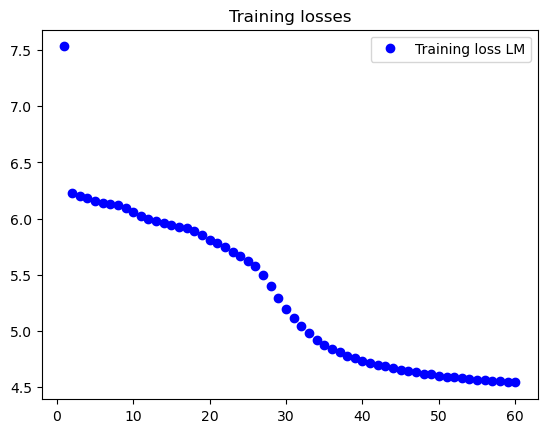

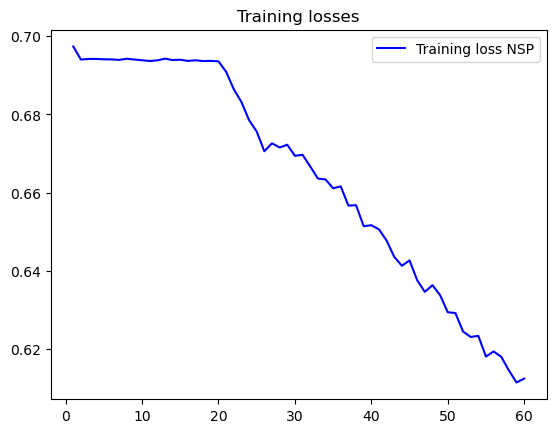

In [113]:
loss_lm = history['loss_lm']
loss_nsp = history['loss_nsp']

epochs = range(1, len(loss_lm) + 1)
plt.plot(epochs, loss_lm, 'bo', label='Training loss LM')
# plt.plot(epochs, loss_nsp, 'b', label='Training loss NSP')
plt.title('Training losses')
plt.legend()

plt.figure()
# plt.plot(epochs, loss_lm, 'bo', label='Training loss LM')
plt.plot(epochs, loss_nsp, 'b', label='Training loss NSP')
plt.title('Training losses')
plt.legend()

plt.show()

In [114]:
len(dataset)

20533

In [115]:
bert_lm.eval()

BERTLM(
  (bert): BERT(
    (embeddings): BERTEmbedding(
      (tok_embedding): Embedding(9778, 20, padding_idx=0)
      (pos_embedding): Embedding(128, 20)
      (seg_embedding): Embedding(2, 20)
      (dropout): Dropout(p=0.1, inplace=False)
      (layer_norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    )
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
      )
      (linear1): Linear(in_features=20, out_features=80, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=80, out_features=20, bias=True)
      (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
    

## Next sentence prediction

In [116]:
dataset[0]['masked_pos']

[4, 10, 15, 23]

In [117]:
y0_lm_pred, y0_nsp_pred = bert_lm(dataset[0]['token_ids'].unsqueeze(dim=0),
                                  dataset[0]['segment_ids'].unsqueeze(dim=0), [dataset[0]['masked_pos']])

In [118]:
y0_nsp_pred

tensor([[-0.3448,  0.3056]], grad_fn=<AddmmBackward0>)

In [119]:
dataset[0]['is_next']

True

In [120]:
y0_nsp = torch.LongTensor([dataset[0]['is_next']])
y0_nsp

tensor([1])

is_next False --> 0, is_next True --> 1
Loss of the next sentence prediction

In [121]:
loss_fn(y0_nsp_pred, y0_nsp)

tensor(0.4199, grad_fn=<NllLossBackward0>)

In [122]:
y0_lm_pred

tensor([[-16.2459,  -1.9119,   1.6688,  ...,  -1.4883,  -4.1272, -11.6579],
        [-17.0972,  -0.9225,   3.8859,  ...,  -1.3576,  -4.0174, -13.4996],
        [-19.8792,   2.8714,  16.1315,  ...,  -1.3759,  -3.4476, -11.9624],
        [-23.3141,  -1.2039,   6.6446,  ...,  -2.8073,  -4.1207, -15.9823]],
       grad_fn=<AddmmBackward0>)

In [123]:
torch.argmax(y0_lm_pred, dim=-1)

tensor([2073, 9572,    2, 8867])

In [124]:
dataset[0]['masked_ids']

tensor([2164, 9572,    2, 8867])

In [125]:
idx2word[7]

','

In [126]:
y0_lm_pred

tensor([[-16.2459,  -1.9119,   1.6688,  ...,  -1.4883,  -4.1272, -11.6579],
        [-17.0972,  -0.9225,   3.8859,  ...,  -1.3576,  -4.0174, -13.4996],
        [-19.8792,   2.8714,  16.1315,  ...,  -1.3759,  -3.4476, -11.9624],
        [-23.3141,  -1.2039,   6.6446,  ...,  -2.8073,  -4.1207, -15.9823]],
       grad_fn=<AddmmBackward0>)

In [127]:
loss_fn(y0_lm_pred, dataset[0]['masked_ids'])

tensor(1.4267, grad_fn=<NllLossBackward0>)

In [128]:
acc = 0
cnt = 0
for i in tqdm(range(n_batches)):
    t, s, y_nsp, masked_pos, masked_ids = make_batch(
        dataset, BATCH_SIZE * i)
    y_lm_pred, y_nsp_pred = bert_lm(t, s, masked_pos)
    acc += torch.sum(torch.argmax(y_nsp_pred, dim=-1) == y_nsp)
    cnt += y_nsp.size()[0]
acc, cnt, acc/cnt

100%|██████████| 161/161 [00:04<00:00, 37.47it/s]


(tensor(14415), 20533, tensor(0.7020))